# Initialize


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import torch
from torchvision import datasets, transforms
import numpy as np
#import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


from model import VAE_priorCategorical, VAE_priorHFM
import metadata as md
from datasets import Dataset_HFM, Dataset_pureHFM, load_dsprites, MNISTDigit2Dataset
from utilities import sample_images
from find_gauge import return_minimum_kl_in_g_range
from find_gauge import plot_kl_multiline_from_dicts, save_individual_plots_from_dicts, create_combined_multiline_plot




In [4]:
device = torch.device('cpu')


# Datasets


## train over ExtendedMNIST


In [5]:
train_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=True
    )

val_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=False
    )

## train over 2MNIST

In [6]:
dataset_2MNIST_train = MNISTDigit2Dataset(train=True, download=True, target_size=60000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
train_loader_2MNIST = DataLoader(dataset_2MNIST_train, batch_size=32, shuffle=True)
batch_images, batch_labels = next(iter(train_loader_2MNIST))
print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")

print("\n––––––––––––––––––––––––––––––––––––––––––––––––––––––\n")

dataset_2MNIST_val = MNISTDigit2Dataset(train=False, download=True, target_size=10000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")
val_loader_2MNIST = DataLoader(dataset_2MNIST_val, batch_size=32, shuffle=True)
print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")

Found 5958 original samples of digit '2'
Generated 60000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
Batch images shape: torch.Size([32, 1, 28, 28])
Batch labels shape: torch.Size([32])
All labels are 2: True

––––––––––––––––––––––––––––––––––––––––––––––––––––––

Found 1032 original samples of digit '2'
Generated 10000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
All labels are 2: True
Batch images shape: torch.Size([32, 1, 28, 28])
Batch labels shape: torch.Size([32])
All labels are 2: True


## dSprites


In [ ]:
train_loader_dSprites, val_loader_dSprites = load_dsprites()


## MNIST


In [7]:
train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=True
    )

val_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=False
    )


## FashionMNIST


In [ ]:
train_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=True
    )

val_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=False
    )
## pureHFM
dataset_HFM_train = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_pureHFM = DataLoader(
    dataset_HFM_train,
    batch_size=md.batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_pureHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=md.batch_size,
    shuffle=False
)
## expandedHFM 32-1024
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_train,
    batch_size=md.batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=md.batch_size,
    shuffle=False
)
# PriorHFM, klG = log2

# PriorCategorical

## CoarseGrainMNIST

### 2MNIST

In [77]:
train_loader = train_loader_2MNIST
val_loader = val_loader_2MNIST
input_dim = 784


In [78]:
g_values = np.arange(0.1, 15, 0.2)
layer_dicts_CGMNIST_ld10_2 = []

# hidden layer = 1
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 1 hidden layer...")
layer_dicts_CGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 2 hidden layers...")
layer_dicts_CGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 3 hidden layers...")
layer_dicts_CGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 4 hidden layers...")
layer_dicts_CGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 5 hidden layers...")
layer_dicts_CGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 6 hidden layers...")
layer_dicts_CGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")

Calculating KL divergences for model with 1 hidden layer...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 3 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 4 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences fo

In [17]:
save_individual_plots_from_dicts(
    layer_dicts_CGMNIST_ld10_2, 
    g_values, 
    "/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/2MNIST_01_15",
    title_prefix="2MNIST Analysis"
)

Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/2MNIST_01_15/kl_divergence_g_0.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/2MNIST_01_15/kl_divergence_g_0.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/2MNIST_01_15/kl_divergence_g_0.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/2MNIST_01_15/kl_divergence_g_0.7.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/2MNIST_01_15/kl_divergence_g_0.9.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/2MNIST_01_15/kl_divergence_g_1.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/2MNIST_01_15/kl_divergence_g_1.3.png
Saved: /Users/enricofrausin

### MNIST

In [79]:
train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 784


In [80]:
g_values = np.arange(0.1, 15, 0.2)
layer_dicts_CGMNIST_ld10_M = []

# hidden layer = 1
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 1 hidden layer...")
layer_dicts_CGMNIST_ld10_M.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 2 hidden layers...")
layer_dicts_CGMNIST_ld10_M.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 3 hidden layers...")
layer_dicts_CGMNIST_ld10_M.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 4 hidden layers...")
layer_dicts_CGMNIST_ld10_M.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 5 hidden layers...")
layer_dicts_CGMNIST_ld10_M.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 6 hidden layers...")
layer_dicts_CGMNIST_ld10_M.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")


Calculating KL divergences for model with 1 hidden layer...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 3 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 4 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences fo

In [20]:
save_individual_plots_from_dicts(
    layer_dicts_CGMNIST_ld10_M, 
    g_values, 
    "/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/MNIST_01_15",
    title_prefix="MNIST Analysis"
)

Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/MNIST_01_15/kl_divergence_g_0.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/MNIST_01_15/kl_divergence_g_0.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/MNIST_01_15/kl_divergence_g_0.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/MNIST_01_15/kl_divergence_g_0.7.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/MNIST_01_15/kl_divergence_g_0.9.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/MNIST_01_15/kl_divergence_g_1.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/MNIST_01_15/kl_divergence_g_1.3.png
Saved: /Users/enricofrausin/Progra

### EMNIST

In [81]:
train_loader = train_loader_EMNIST
val_loader = val_loader_EMNIST
input_dim = 784

In [82]:
g_values=np.arange(0.1, 15, 0.2)
layer_dicts_CGMNIST_ld10_E = []

# hidden layer = 1
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 1 hidden layer...")
layer_dicts_CGMNIST_ld10_E.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 2 hidden layers...")
layer_dicts_CGMNIST_ld10_E.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 3 hidden layers...")
layer_dicts_CGMNIST_ld10_E.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 4 hidden layers...")
layer_dicts_CGMNIST_ld10_E.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 5 hidden layers...")
layer_dicts_CGMNIST_ld10_E.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 6 hidden layers...")
layer_dicts_CGMNIST_ld10_E.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")


Calculating KL divergences for model with 1 hidden layer...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 3 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 4 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences fo

In [23]:
save_individual_plots_from_dicts(
    layer_dicts_CGMNIST_ld10_E, 
    g_values, 
    "/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/EMNIST_01_15",
    title_prefix="EMNIST Analysis"
)

Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/EMNIST_01_15/kl_divergence_g_0.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/EMNIST_01_15/kl_divergence_g_0.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/EMNIST_01_15/kl_divergence_g_0.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/EMNIST_01_15/kl_divergence_g_0.7.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/EMNIST_01_15/kl_divergence_g_0.9.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/EMNIST_01_15/kl_divergence_g_1.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/EMNIST_01_15/kl_divergence_g_1.3.png
Saved: /Users/enricofrausin

## FineGrainMNIST

### EMNIST

In [70]:
train_loader = train_loader_EMNIST
val_loader = val_loader_EMNIST
input_dim = 784


In [71]:
g_values=np.arange(0.1, 15, 0.2)
layer_dicts_FGMNIST_ld10_E = []

# hidden layer = 1
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 1 hidden layer...")
layer_dicts_FGMNIST_ld10_E.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 2 hidden layers...")
layer_dicts_FGMNIST_ld10_E.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 3 hidden layers...")
layer_dicts_FGMNIST_ld10_E.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 4 hidden layers...")
layer_dicts_FGMNIST_ld10_E.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 5 hidden layers...")
layer_dicts_FGMNIST_ld10_E.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 6 hidden layers...")
layer_dicts_FGMNIST_ld10_E.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")


Calculating KL divergences for model with 1 hidden layer...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 3 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 4 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences fo

In [45]:
save_individual_plots_from_dicts(
    layer_dicts_FGMNIST_ld10_E, 
    g_values, 
    "/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/EMNIST_01_15",
    title_prefix="EMNIST Analysis"
)

Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/EMNIST_01_15/kl_divergence_g_0.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/EMNIST_01_15/kl_divergence_g_0.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/EMNIST_01_15/kl_divergence_g_0.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/EMNIST_01_15/kl_divergence_g_0.7.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/EMNIST_01_15/kl_divergence_g_0.9.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/EMNIST_01_15/kl_divergence_g_1.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/EMNIST_01_15/kl_divergence_g_1.3.png
Saved: /Users/enricofrausin/Programmazion

### MNIST

In [72]:
train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 784


In [73]:

g_values = np.arange(0.1, 15, 0.2)
layer_dicts_FGMNIST_ld10_M = []

# hidden layer = 1
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 1 hidden layer...")
layer_dicts_FGMNIST_ld10_M.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 2 hidden layers...")
layer_dicts_FGMNIST_ld10_M.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 3 hidden layers...")
layer_dicts_FGMNIST_ld10_M.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 4 hidden layers...")
layer_dicts_FGMNIST_ld10_M.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 5 hidden layers...")
layer_dicts_FGMNIST_ld10_M.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 6 hidden layers...")
layer_dicts_FGMNIST_ld10_M.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")


Calculating KL divergences for model with 1 hidden layer...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 3 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 4 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences fo

In [48]:

save_individual_plots_from_dicts(
    layer_dicts_FGMNIST_ld10_M, 
    g_values, 
    "/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/MNIST_01_15",
    title_prefix="MNIST Analysis"
)

Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/MNIST_01_15/kl_divergence_g_0.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/MNIST_01_15/kl_divergence_g_0.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/MNIST_01_15/kl_divergence_g_0.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/MNIST_01_15/kl_divergence_g_0.7.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/MNIST_01_15/kl_divergence_g_0.9.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/MNIST_01_15/kl_divergence_g_1.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/MNIST_01_15/kl_divergence_g_1.3.png
Saved: /Users/enricofrausin/Programmazione/Pytho

### 2MNIST

In [74]:
train_loader = train_loader_2MNIST
val_loader = val_loader_2MNIST
input_dim = 784


In [75]:

g_values = np.arange(0.1, 15, 0.2)
layer_dicts_FGMNIST_ld10_2 = []

# hidden layer = 1
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 1 hidden layer...")
layer_dicts_FGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 2 hidden layers...")
layer_dicts_FGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 3 hidden layers...")
layer_dicts_FGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 4 hidden layers...")
layer_dicts_FGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 5 hidden layers...")
layer_dicts_FGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 6 hidden layers...")
layer_dicts_FGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")


Calculating KL divergences for model with 1 hidden layer...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 3 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 4 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences fo

In [52]:
save_individual_plots_from_dicts(
    layer_dicts_FGMNIST_ld10_2, 
    g_values, 
    "/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/2MNIST_01_15",
    title_prefix="2MNIST Analysis"
)

Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/2MNIST_01_15/kl_divergence_g_0.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/2MNIST_01_15/kl_divergence_g_0.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/2MNIST_01_15/kl_divergence_g_0.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/2MNIST_01_15/kl_divergence_g_0.7.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/2MNIST_01_15/kl_divergence_g_0.9.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/2MNIST_01_15/kl_divergence_g_1.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/2MNIST_01_15/kl_divergence_g_1.3.png
Saved: /Users/enricofrausin/Programmazion

## train over EMNIST


In [8]:
train_loader = train_loader_EMNIST
val_loader = val_loader_EMNIST
input_dim = 784



### latent_dim = 8



In [24]:

g_values=np.arange(0.1, 15, 0.2)
layer_dicts_EMNIST_single_shot = []



In [25]:
# hidden layer = 1
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 1 hidden layer...")
layer_dicts_EMNIST_single_shot.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 2 hidden layers...")
layer_dicts_EMNIST_single_shot.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 3 hidden layers...")
layer_dicts_EMNIST_single_shot.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 4 hidden layers...")
layer_dicts_EMNIST_single_shot.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 5 hidden layers...")
layer_dicts_EMNIST_single_shot.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 6 hidden layers...")
layer_dicts_EMNIST_single_shot.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=7, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_7hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 7 hidden layers...")
layer_dicts_EMNIST_single_shot.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")


Calculating KL divergences for model with 1 hidden layer...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Total permutations processed: 40320, Minimum KL: 0.20036077499389648, Best permutation: (2, 7, 0, 3, 5, 4, 1, 6)
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Total permutations processed: 40320, Minimum KL: 0.18168354034423828, Best permutation: (0, 4, 2, 1, 3, 5, 6, 7)
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 3 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Total permutations processed: 40320, Minimum KL: 0.18607854843139648, Best permutation: (0, 1, 4, 5, 2, 7, 3, 6)
Calcul

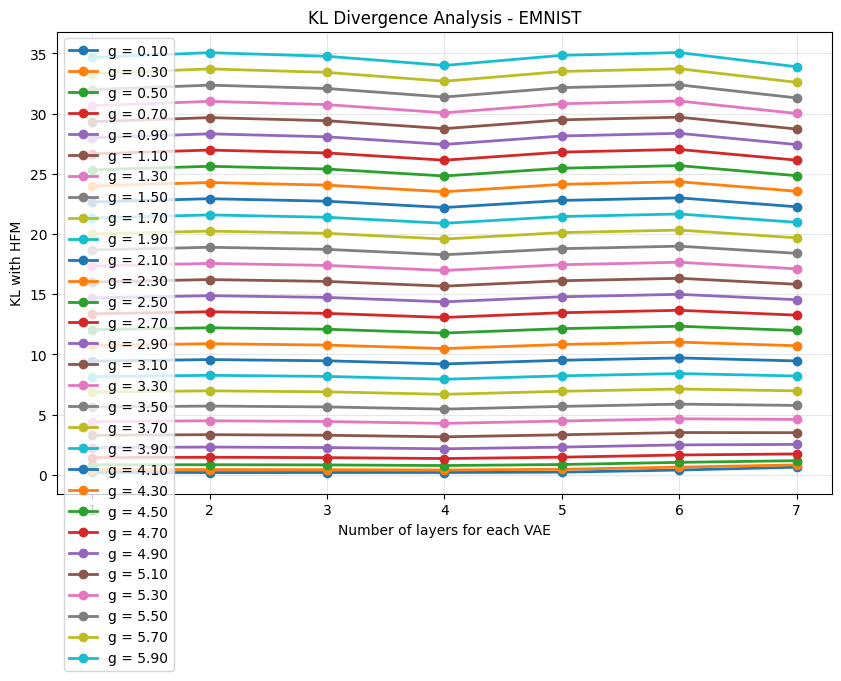

In [22]:
# Create multi-line plot
plot_kl_multiline_from_dicts(layer_dicts_EMNIST_single_shot, g_values, title="KL Divergence Analysis - EMNIST")



In [26]:

save_individual_plots_from_dicts(
    layer_dicts_EMNIST_single_shot, 
    g_values, 
    "/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/EMNIST_01_15/",
    title_prefix="EMNIST Analysis"
)


Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/EMNIST_01_15/kl_divergence_g_0.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/EMNIST_01_15/kl_divergence_g_0.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/EMNIST_01_15/kl_divergence_g_0.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/EMNIST_01_15/kl_divergence_g_0.7.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/EMNIST_01_15/kl_divergence_g_0.9.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/EMNIST_01_15/kl_divergence_g_1.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/EMNIST_01_15/kl_divergence_g_1.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/EMNIST_01_15/kl_divergence_g_1.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/EMNIST_01_15/kl_divergence_g_1.7.png
S

### 10 features

In [9]:
g_values=np.arange(0.1, 5, 0.2)
layer_dicts_EMNIST_ld10 = []

# hidden layer = 1
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 1 hidden layer...")
layer_dicts_EMNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 2 hidden layers...")
layer_dicts_EMNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 3 hidden layers...")
layer_dicts_EMNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 4 hidden layers...")
layer_dicts_EMNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 5 hidden layers...")
layer_dicts_EMNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=10, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 6 hidden layers...")
layer_dicts_EMNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")


Calculating KL divergences for model with 1 hidden layer...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 3 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 4 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences fo

In [16]:

save_individual_plots_from_dicts(
    layer_dicts_EMNIST_ld10, 
    g_values, 
    "/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/EMNIST_01_15",
    title_prefix="EMNIST Analysis"
)


Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/EMNIST_01_15/kl_divergence_g_0.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/EMNIST_01_15/kl_divergence_g_0.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/EMNIST_01_15/kl_divergence_g_0.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/EMNIST_01_15/kl_divergence_g_0.7.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/EMNIST_01_15/kl_divergence_g_0.9.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/EMNIST_01_15/kl_divergence_g_1.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/EMNIST_01_15/kl_divergence_g_1.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/EMNIST_01_15/kl_divergence_g_1.5.png
Saved: /Users/enricofrau

## train over 2MNIST

In [10]:
train_loader = train_loader_2MNIST
val_loader = val_loader_2MNIST
input_dim = 784


In [ ]:
g_values = np.arange(0.1, 15, 0.2)
layer_dicts_CGMNIST_ld10_2 = []

# hidden layer = 1
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 1 hidden layer...")
layer_dicts_CGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 2 hidden layers...")
layer_dicts_CGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 3 hidden layers...")
layer_dicts_CGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 4 hidden layers...")
layer_dicts_CGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 5 hidden layers...")
layer_dicts_CGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 6 hidden layers...")
layer_dicts_CGMNIST_ld10_2.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")

### latent_dim = 8


In [9]:

g_values=np.arange(0.1, 15, 0.2)
layer_dicts_2MNIST = []


In [7]:

# hidden layer = 1
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 1 hidden layer...")
layer_dicts_2MNIST.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 2 hidden layers...")
layer_dicts_2MNIST.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 3 hidden layers...")
layer_dicts_2MNIST.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 4 hidden layers...")
layer_dicts_2MNIST.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 5 hidden layers...")
layer_dicts_2MNIST.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

# my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
# my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
# print("Calculating KL divergences for model with 6 hidden layers...")
# layer_dicts_2MNIST.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
# print("--------------------------\n")



Calculating KL divergences for model with 1 hidden layer...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 3 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 4 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences fo

In [8]:

# Save individual plots
save_individual_plots_from_dicts(
    layer_dicts_2MNIST, 
    g_values, 
    "/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15/",
    title_prefix="MNIST Analysis"
)


Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15/kl_divergence_g_0.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15/kl_divergence_g_0.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15/kl_divergence_g_0.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15/kl_divergence_g_0.7.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15/kl_divergence_g_0.9.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15/kl_divergence_g_1.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15/kl_divergence_g_1.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15/kl_divergence_g_1.5.png
Saved: /Users/enricofrausin/Prog

#### BRUTE FORCE

In [11]:

g_values=np.arange(0.1, 15, 0.2)
layer_dicts_2MNIST = []



# hidden layer = 1
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 1 hidden layer...")
layer_dicts_2MNIST.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values, brute_force=True))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 2 hidden layers...")
layer_dicts_2MNIST.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values, brute_force=True))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 3 hidden layers...")
layer_dicts_2MNIST.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values, brute_force=True))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 4 hidden layers...")
layer_dicts_2MNIST.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values, brute_force=True))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 5 hidden layers...")
layer_dicts_2MNIST.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values, brute_force=True))
print("---------------\n")

# my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
# my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
# print("Calculating KL divergences for model with 6 hidden layers...")
# layer_dicts_2MNIST.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values, brute_force=True))
# print("--------------------------\n")


Calculating KL divergences for model with 1 hidden layer...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Total permutations processed: 40320, Minimum KL: 1.5023846626281738, Best permutation: (5, 2, 7, 6, 3, 1, 4, 0)
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Total permutations processed: 40320, Minimum KL: 1.4542102813720703, Best permutation: (2, 7, 0, 6, 4, 5, 3, 1)
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 3 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Total permutations processed: 40320, Minimum KL: 1.4274535179138184, Best permutation: (2, 4, 6, 3, 7, 5, 1, 0)
Calculati

In [12]:

# Save individual plots
save_individual_plots_from_dicts(
    layer_dicts_2MNIST, 
    g_values, 
    "/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15_BF/",
    title_prefix="MNIST Analysis"
)


Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15_BF/kl_divergence_g_0.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15_BF/kl_divergence_g_0.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15_BF/kl_divergence_g_0.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15_BF/kl_divergence_g_0.7.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15_BF/kl_divergence_g_0.9.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15_BF/kl_divergence_g_1.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15_BF/kl_divergence_g_1.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/8features/2MNIST_01_15_BF/kl_divergence_g_1.5.png
Saved: /

### 10 features

In [11]:
g_values = np.arange(0.1, 5, 0.2)
layer_dicts_2MNIST_ld10 = []

# hidden layer = 1
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 1 hidden layer...")
layer_dicts_2MNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 2 hidden layers...")
layer_dicts_2MNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 3 hidden layers...")
layer_dicts_2MNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 4 hidden layers...")
layer_dicts_2MNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 5 hidden layers...")
layer_dicts_2MNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 6 hidden layers...")
layer_dicts_2MNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")


Calculating KL divergences for model with 1 hidden layer...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 3 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 4 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences fo

In [18]:
save_individual_plots_from_dicts(
    layer_dicts_2MNIST_ld10, 
    g_values, 
    "/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/2MNIST_01_15",
    title_prefix="MNIST Analysis"
)

Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/2MNIST_01_15/kl_divergence_g_0.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/2MNIST_01_15/kl_divergence_g_0.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/2MNIST_01_15/kl_divergence_g_0.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/2MNIST_01_15/kl_divergence_g_0.7.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/2MNIST_01_15/kl_divergence_g_0.9.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/2MNIST_01_15/kl_divergence_g_1.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/2MNIST_01_15/kl_divergence_g_1.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/2MNIST_01_15/kl_divergence_g_1.5.png
Saved: /Users/enricofrau

## train over MNIST


**OSS:** The analysis was executed to some mixed lambda trained VAE too (lamda = 1 for layers 1,2,3,4; lambda = 0.1 for layers 5,6), and the results are approxiamtely the same.

In [12]:
train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 784


### KL and <m_s> vs g

In [39]:
from utilities import get_empirical_latent_distribution
from find_gauge import flip_gauge_bits, find_minimum_kl_brute_force
from find_gauge import plot_expected_ms_vs_g, plot_expected_kl_vs_g

In [47]:
#1hl
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))

<All keys matched successfully>

In [48]:
print("Obtaining the internal latent distribution of the model...")
empirical_probs, total_samples = get_empirical_latent_distribution(my_model, train_loader, device=device)
good_gauged_dict = flip_gauge_bits(empirical_probs)
print("Evaluating the best gauge of the latent s")
minimum_kl, best_permutation, gauged_states = find_minimum_kl_brute_force(good_gauged_dict, g=0.6, return_additional_info=True)

Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent s
Total permutations processed: 40320, Minimum KL: 1.1855382919311523, Best permutation: (5, 6, 4, 0, 1, 3, 2, 7)


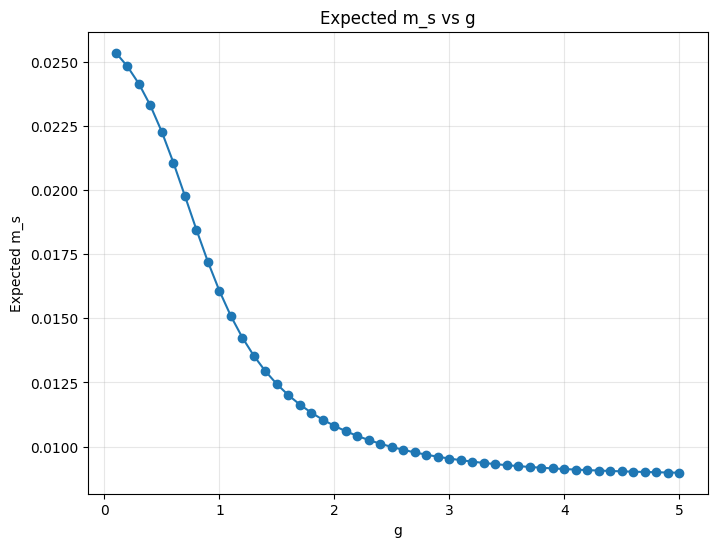

In [52]:
plot_expected_ms_vs_g(gauged_states)

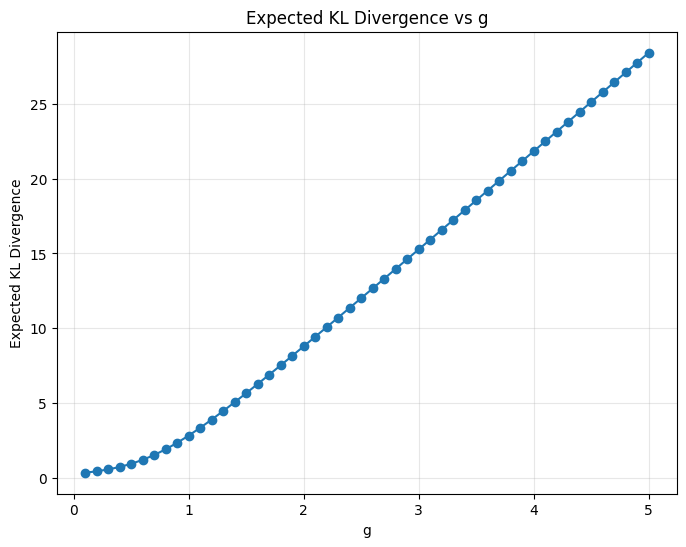

In [45]:
plot_expected_kl_vs_g(gauged_states)

### Previous calculations

In [ ]:
# for g in np.arange(0.1, 2, 0.2):
#     print("____________________________________________")
#     print(f"Processing g = {g}")

#     var_name = f"kl_divergences_lmb01_{str(round(g, 2)).replace('.', '')}"
#     globals()[var_name] = []

#     # hidden layer = 1
#     my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
#     my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
#     globals()[var_name].append(return_minimum_kl(my_model, train_loader, device, g))

#     # hidden layer = 2
#     my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
#     my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
#     globals()[var_name].append(return_minimum_kl(my_model, train_loader, device, g))

#     # hidden layer = 3
#     my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
#     my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
#     globals()[var_name].append(return_minimum_kl(my_model, train_loader, device, g))

#     # hidden layer = 4
#     my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
#     my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
#     globals()[var_name].append(return_minimum_kl(my_model, train_loader, device, g))

#     # hidden layer = 5
#     my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
#     my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
#     globals()[var_name].append(return_minimum_kl(my_model, train_loader, device, g))

#     # hidden layer = 6
#     my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
#     my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
#     globals()[var_name].append(return_minimum_kl(my_model, train_loader, device, g))



# data_to_save = {}
# for g in np.arange(0.1, 2, 0.2):
#     var_name = f"kl_divergences_lmb01_{str(round(g, 2)).replace('.', '')}"
#     if var_name in globals():
#         data_to_save[var_name] = np.array(globals()[var_name])


# np.savez('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/kl_divergences_priorCategorical_MNIST_lmb01.npz', **data_to_save)

# plot_kl_multiline(np.arange(0.1, 2, 0.2), var_name_prefix="kl_divergences_lmb01", title="Lambda = 0.1")

# save_individual_plots("/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/kl_divergence_priorCategorical_MNIST/lmb01", np.arange(0.1, 2, 0.2))


____________________________________________
Processing g = 0.1
Feature frequencies: [0.49583333 0.54381667 0.46478333 0.45595    0.44476667 0.52273333
 0.47725    0.4425    ], Sorted indices: [1 5 0 6 2 3 4 7]
Processed 10000 permutations, current minimum KL: 0.33234596252441406, best permutation: (1, 3, 6, 2, 0, 5, 4, 7)
Processed 20000 permutations, current minimum KL: 0.33234596252441406, best permutation: (1, 3, 6, 2, 0, 5, 4, 7)
Processed 30000 permutations, current minimum KL: 0.33234596252441406, best permutation: (1, 3, 6, 2, 0, 5, 4, 7)
Processed 40000 permutations, current minimum KL: 0.33234596252441406, best permutation: (1, 3, 6, 2, 0, 5, 4, 7)
Minimum KL divergence: 0.33234596252441406
Feature frequencies: [0.46023333 0.55815    0.4373     0.46316667 0.51475    0.5356
 0.46705    0.5171    ], Sorted indices: [1 5 7 4 6 3 0 2]
Processed 10000 permutations, current minimum KL: 0.29062747955322266, best permutation: (0, 3, 1, 2, 5, 4, 6, 7)
Processed 20000 permutations, cur

### latent_dim = 8


In [54]:
g_values = np.arange(0.1, 15, 0.2)
layer_dicts_MNIST_single_shot = []

# hidden layer = 1
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 1 hidden layer...")
layer_dicts_MNIST_single_shot.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 2 hidden layers...")
layer_dicts_MNIST_single_shot.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 3 hidden layers...")
layer_dicts_MNIST_single_shot.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 4 hidden layers...")
layer_dicts_MNIST_single_shot.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 5 hidden layers...")
layer_dicts_MNIST_single_shot.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 6 hidden layers...")
layer_dicts_MNIST_single_shot.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.6, device=device, num_hidden_layers=7, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_7hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 7 hidden layers...")
layer_dicts_MNIST_single_shot.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")



Calculating KL divergences for model with 1 hidden layer...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Total permutations processed: 40320, Minimum KL: 0.32763671875, Best permutation: (5, 6, 4, 0, 1, 7, 2, 3)
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Total permutations processed: 40320, Minimum KL: 0.2633786201477051, Best permutation: (0, 1, 3, 2, 5, 7, 6, 4)
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 3 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Total permutations processed: 40320, Minimum KL: 0.2898993492126465, Best permutation: (3, 5, 7, 0, 4, 6, 1, 2)
Calculating th

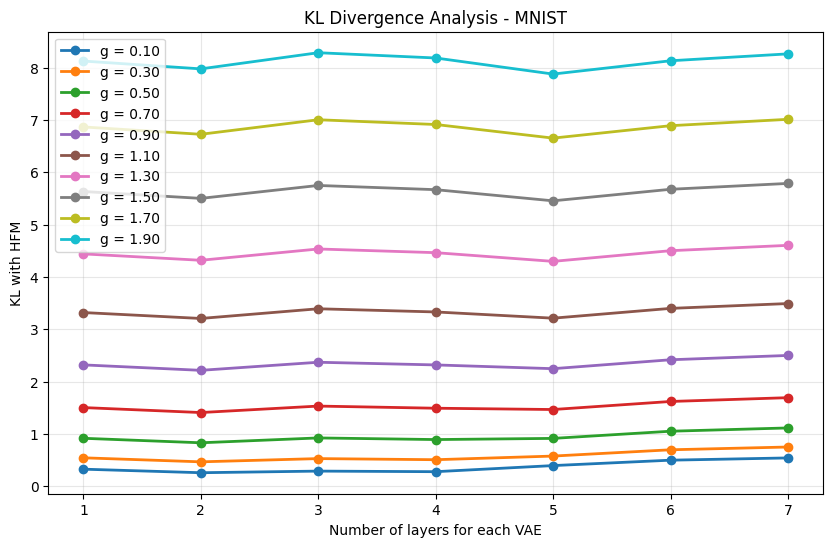

In [ ]:

plot_kl_multiline_from_dicts(layer_dicts_MNIST_single_shot, g_values, title="KL Divergence Analysis - MNIST")

In [ ]:

# Save individual plots
save_individual_plots_from_dicts(
    layer_dicts_MNIST_single_shot, 
    g_values, 
    "/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MNIST_01_15/",
    title_prefix="MNIST Analysis"
)


Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MNIST_01_15_sa/kl_divergence_g_0.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MNIST_01_15_sa/kl_divergence_g_0.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MNIST_01_15_sa/kl_divergence_g_0.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MNIST_01_15_sa/kl_divergence_g_0.7.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MNIST_01_15_sa/kl_divergence_g_0.9.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MNIST_01_15_sa/kl_divergence_g_1.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MNIST_01_15_sa/kl_divergence_g_1.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MNIST_01_15_sa/kl_divergence_g_1.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MNIST_01_15_sa/kl_dive

In [ ]:

# Create and save combined plot
create_combined_multiline_plot(
    layer_dicts_MNIST, 
    g_values,
    save_path="/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/kl_divergence_priorCategorical_MNIST/kl_divergences_combined_depth_analysis.png",
    title="KL Divergence vs Number of Layers - MNIST Dataset"
)

### 10 features

In [13]:
g_values = np.arange(0.1, 5, 0.2)
layer_dicts_MNIST_ld10 = []

# hidden layer = 1
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 1 hidden layer...")
layer_dicts_MNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 2 hidden layers...")
layer_dicts_MNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 3 hidden layers...")
layer_dicts_MNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 4 hidden layers...")
layer_dicts_MNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 5 hidden layers...")
layer_dicts_MNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 6 hidden layers...")
layer_dicts_MNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")

my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=10, decrease_rate=0.6, device=device, num_hidden_layers=7, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_7hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 7 hidden layers...")
layer_dicts_MNIST_ld10.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")


Calculating KL divergences for model with 1 hidden layer...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 3 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 4 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences fo

In [19]:
save_individual_plots_from_dicts(
    layer_dicts_MNIST_ld10, 
    g_values, 
    "/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/MNIST_01_15",
    title_prefix="MNIST Analysis"
)


Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/MNIST_01_15/kl_divergence_g_0.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/MNIST_01_15/kl_divergence_g_0.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/MNIST_01_15/kl_divergence_g_0.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/MNIST_01_15/kl_divergence_g_0.7.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/MNIST_01_15/kl_divergence_g_0.9.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/MNIST_01_15/kl_divergence_g_1.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/MNIST_01_15/kl_divergence_g_1.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/MNIST_01_15/kl_divergence_g_1.5.png
Saved: /Users/enricofrausin/Prog

# Average

In [39]:
# Number of repetitions for averaging
num_repetitions = 5

# Initialize list to store all repetitions
all_repetitions = []

for rep in range(num_repetitions):
    print(f"\n========== REPETITION {rep + 1}/{num_repetitions} ==========")
    layer_dicts_current_rep = []
    
    # hidden layer = 1
    my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
    my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
    print("Calculating KL divergences for model with 1 hidden layer...")
    layer_dicts_current_rep.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
    print("---------------\n")

    my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
    my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
    print("Calculating KL divergences for model with 2 hidden layers...")
    layer_dicts_current_rep.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
    print("---------------\n")

    my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
    my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
    print("Calculating KL divergences for model with 3 hidden layers...")
    layer_dicts_current_rep.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
    print("---------------\n")

    my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
    my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
    print("Calculating KL divergences for model with 4 hidden layers...")
    layer_dicts_current_rep.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
    print("---------------\n")

    my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
    my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
    print("Calculating KL divergences for model with 5 hidden layers...")
    layer_dicts_current_rep.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
    print("---------------\n")

    my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
    my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
    print("Calculating KL divergences for model with 6 hidden layers...")
    layer_dicts_current_rep.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
    print("--------------------------\n")
    
    all_repetitions.append(layer_dicts_current_rep)

# Average the results across all repetitions
print("Computing averages across repetitions...")
layer_dicts_EMNIST = []

for layer_idx in range(6):  # 6 layers
    averaged_dict = {}
    
    # Get all g_values from first repetition (assuming all reps have same g_values)
    g_keys = list(all_repetitions[0][layer_idx].keys())
    
    for g_key in g_keys:
        # Collect values for this g across all repetitions
        values = [all_repetitions[rep][layer_idx][g_key] for rep in range(num_repetitions)]
        # Average them
        averaged_dict[g_key] = np.mean(values)
    
    layer_dicts_EMNIST.append(averaged_dict)

print(f"Completed {num_repetitions} repetitions and averaged results.")


========== REPETITION 1/5 ==========
Calculating KL divergences for model with 1 hidden layer...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Evaluating the best gauge of the latent states...
Total permutations processed: 40320, Minimum KL: 0.20020198822021484, Best permutation: (2, 7, 0, 3, 5, 4, 1, 6)
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Total permutations processed: 40320, Minimum KL: 0.20020198822021484, Best permutation: (2, 7, 0, 3, 5, 4, 1, 6)
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Evaluating the best gauge of the latent states...
Total permutations processed: 4

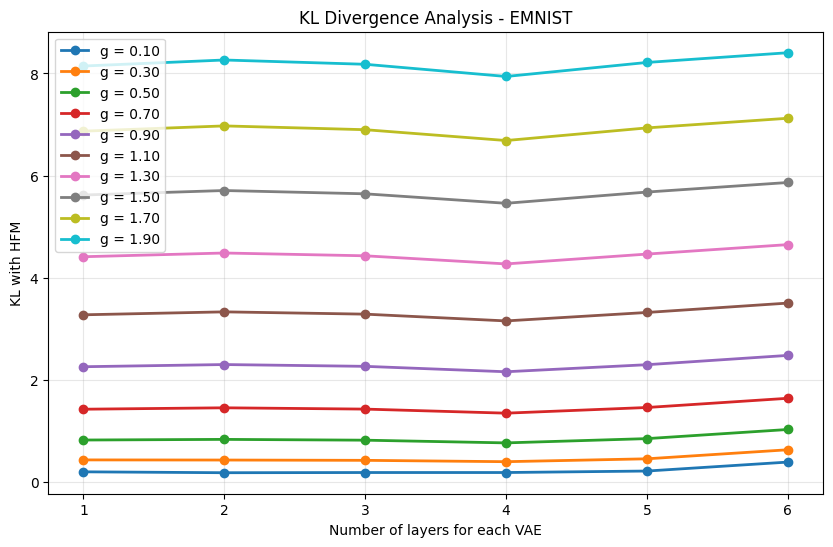

In [40]:
g_values = np.arange(0.1, 2, 0.2)

# Create multi-line plot
plot_kl_multiline_from_dicts(layer_dicts_EMNIST, g_values, title="KL Divergence Analysis - EMNIST")

In [42]:
# Save individual plots
save_individual_plots_from_dicts(
    layer_dicts_EMNIST, 
    g_values, 
    "/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MEAN/kl_divergence_priorCategorical_EMNIST/",
    title_prefix="EMNIST Analysis"
)

Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MEAN/kl_divergence_priorCategorical_EMNIST/kl_divergence_g_0.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MEAN/kl_divergence_priorCategorical_EMNIST/kl_divergence_g_0.3.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MEAN/kl_divergence_priorCategorical_EMNIST/kl_divergence_g_0.5.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MEAN/kl_divergence_priorCategorical_EMNIST/kl_divergence_g_0.7.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MEAN/kl_divergence_priorCategorical_EMNIST/kl_divergence_g_0.9.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MEAN/kl_divergence_priorCategorical_EMNIST/kl_divergence_g_1.1.png
Saved: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/MEAN/kl_divergence_priorCategorical_EMNIST/kl_divergence_g_0.7.png
Saved: /Users

Plot saved to: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/comparison_layer_4.png


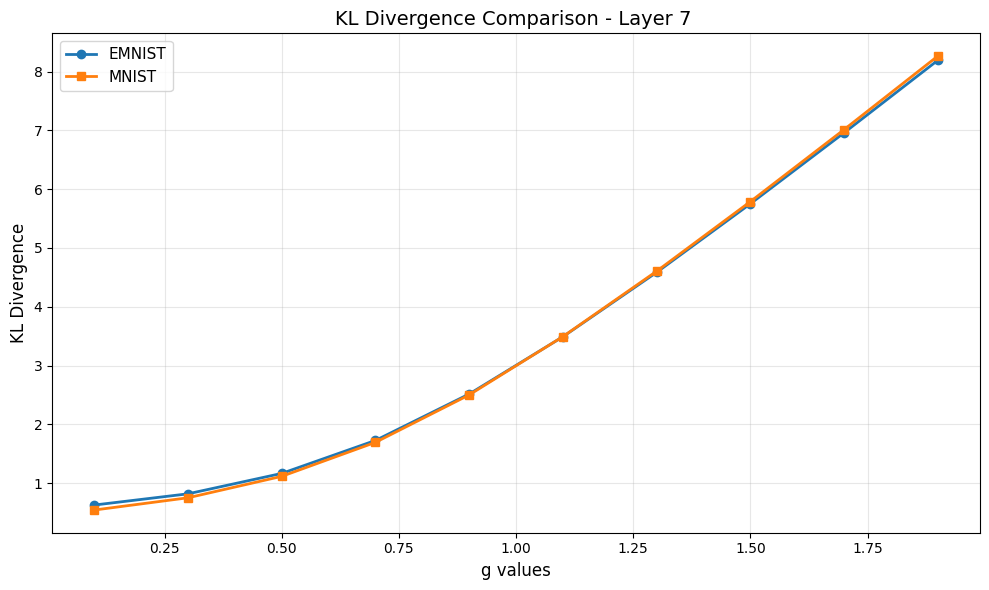

In [46]:
compare_datasets_by_layer_restricted(
    layer_dicts_EMNIST_single_shot, 
    layer_dicts_MNIST_single_shot,
    g_values=g_values, 
    layer_index=6,
    save_path="/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/comparison_layer_4.png"
)

# Compare

In [1]:
from find_gauge import compare_all_layers, compare_datasets_by_layer, create_combined_comparison_plot

## 8 features

Plot saved to: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/comparison_layer_4.png


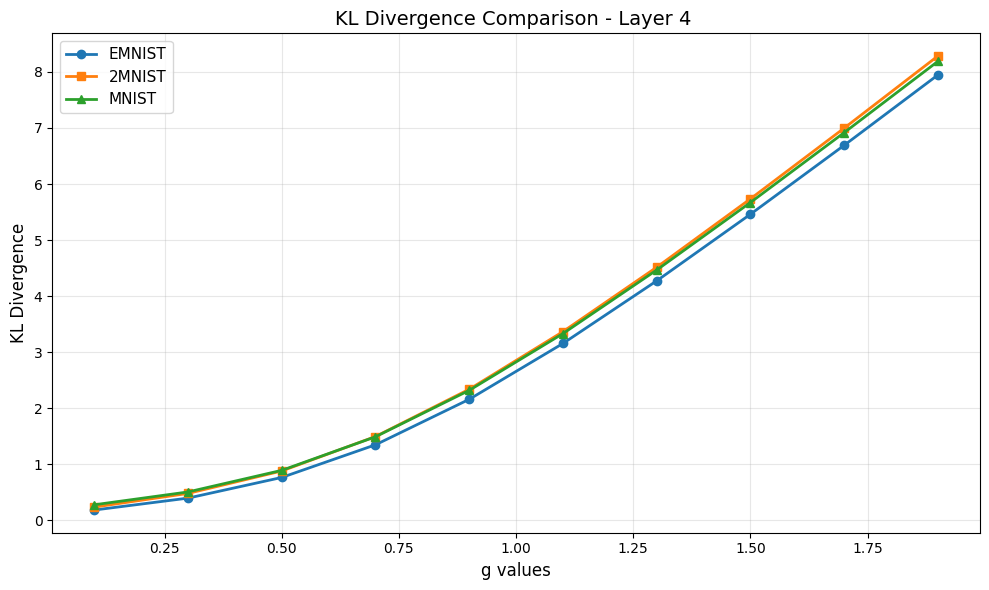

In [ ]:


# Compare a specific layer (e.g., layer 1, which is index 0)
compare_datasets_by_layer(
    layer_dicts_EMNIST_single_shot, 
    layer_dicts_2MNIST, 
    layer_dicts_MNIST_single_shot,
    g_values, 
    layer_index=3,
    save_path="/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/comparison_layer_4.png"
)


Plot saved to: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/dataset_comparisons/comparison_layer_1.png


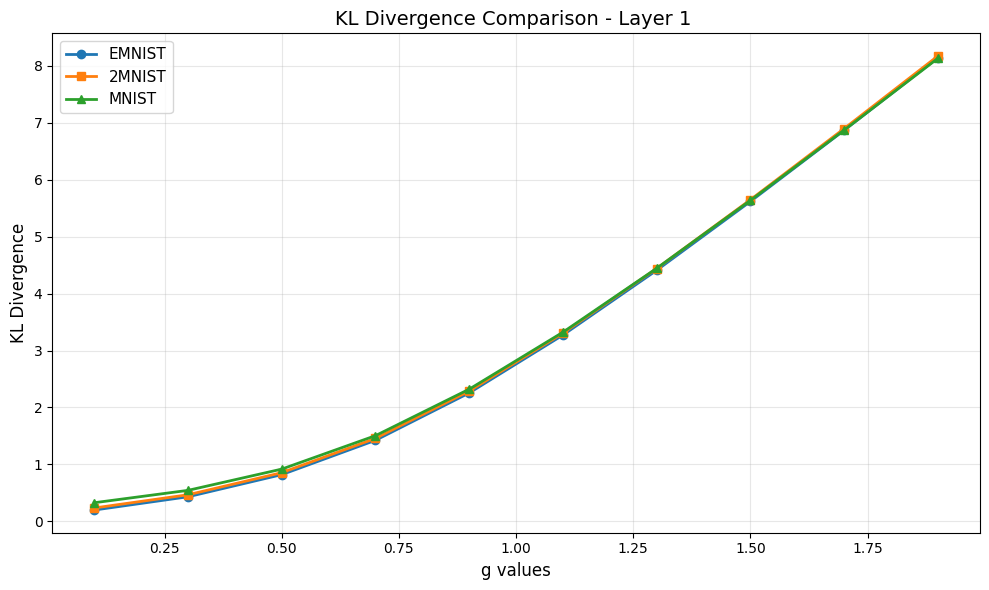

Plot saved to: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/dataset_comparisons/comparison_layer_2.png


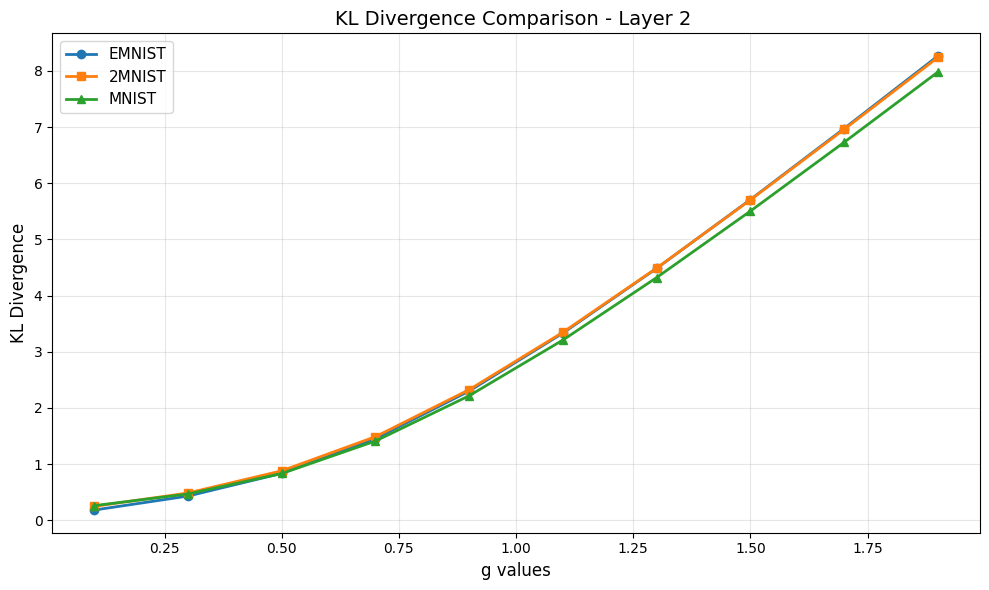

Plot saved to: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/dataset_comparisons/comparison_layer_3.png


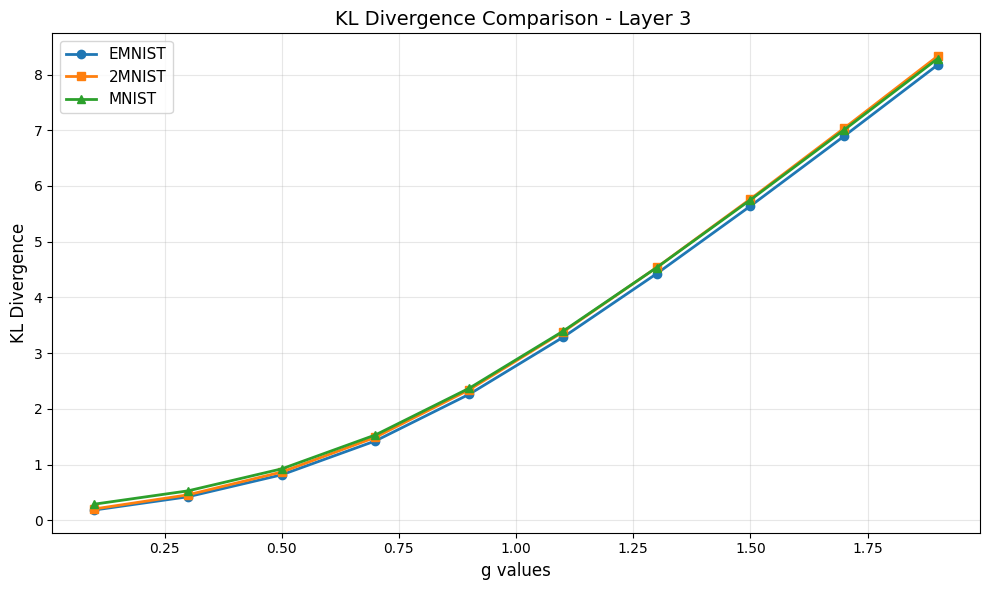

Plot saved to: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/dataset_comparisons/comparison_layer_4.png


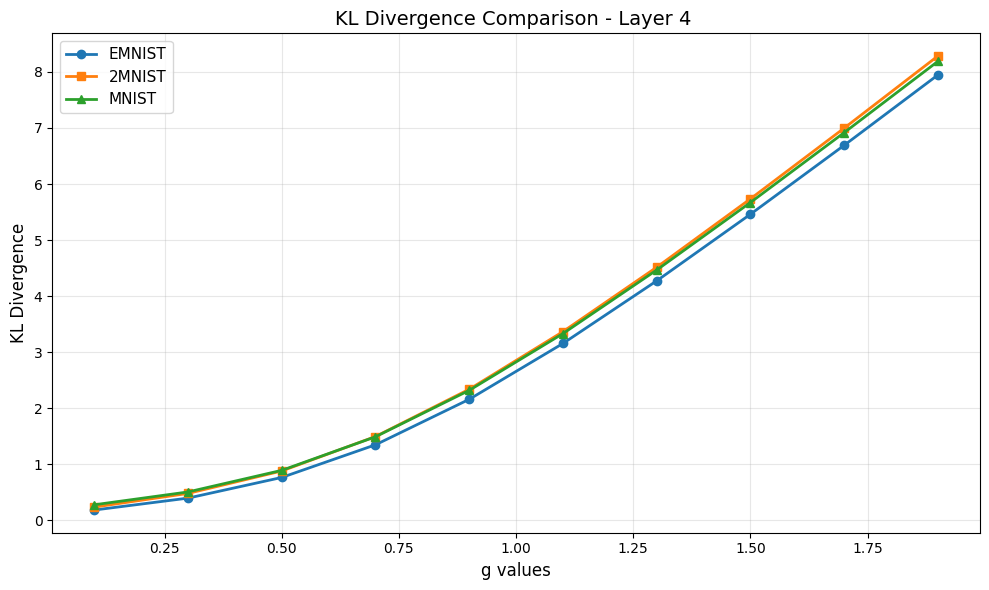

Plot saved to: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/dataset_comparisons/comparison_layer_5.png


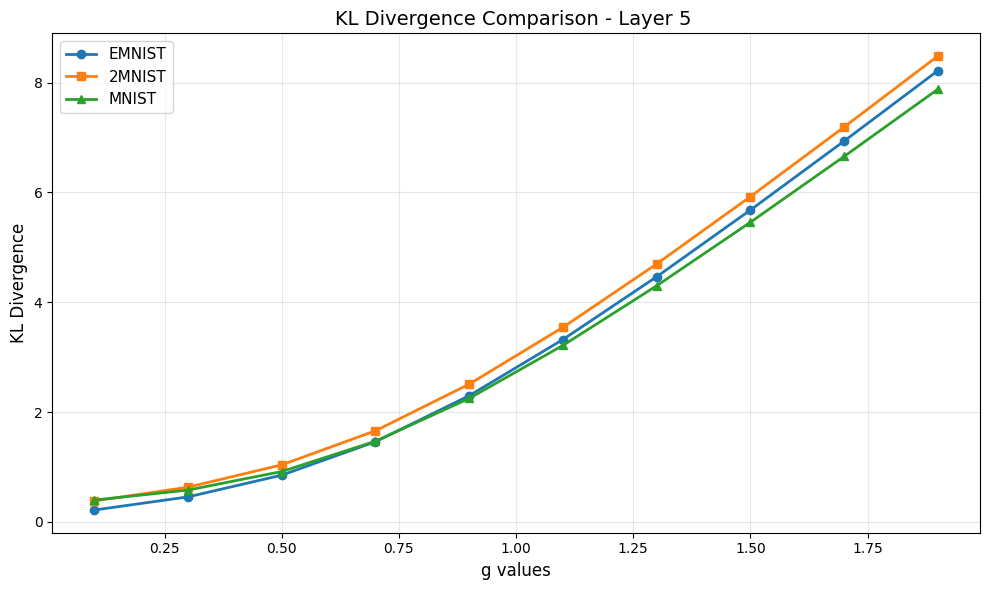

In [29]:
# Compare all available layers
compare_all_layers(
    layer_dicts_EMNIST_single_shot, 
    layer_dicts_2MNIST, 
    layer_dicts_MNIST_single_shot,
    g_values,
    save_dir="/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/dataset_comparisons"
)

## 10 features

### Separate train

Combined plot saved to: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/combined_dataset_comparison.png


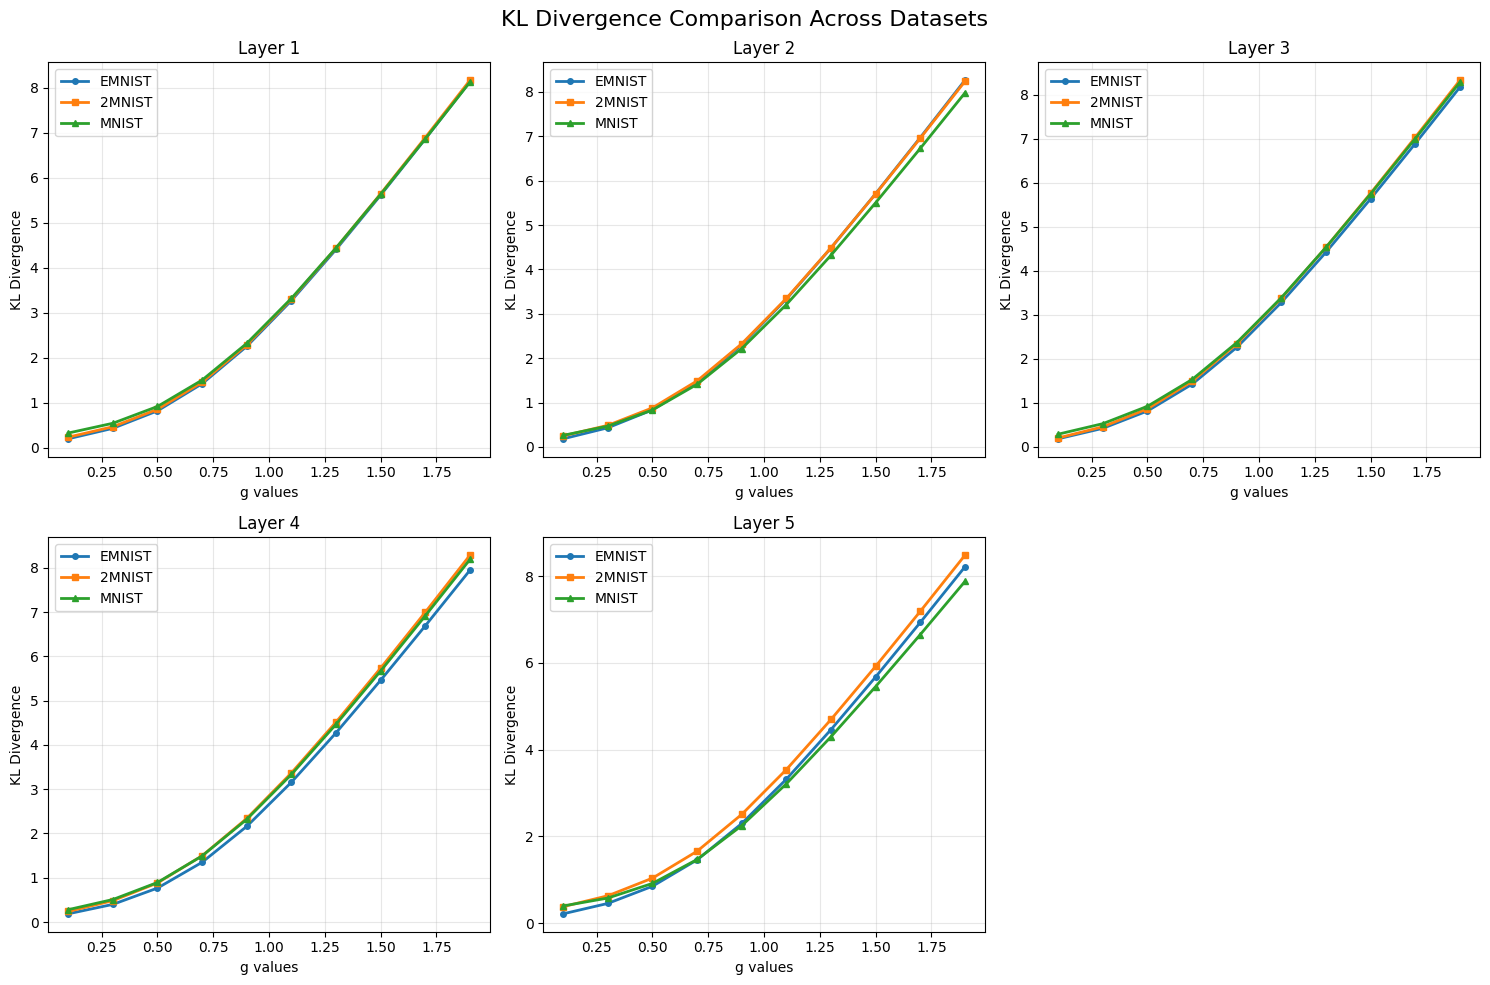

In [ ]:
create_combined_comparison_plot(
    layer_dicts_EMNIST_ld10, 
    layer_dicts_2MNIST_ld10, 
    layer_dicts_MNIST_ld10,
    g_values,
    save_path="/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/combined_dataset_comparison.png"
)

### CoarseGrain

Combined plot saved to: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/comparisons/combined_dataset_comparison_01_2.png


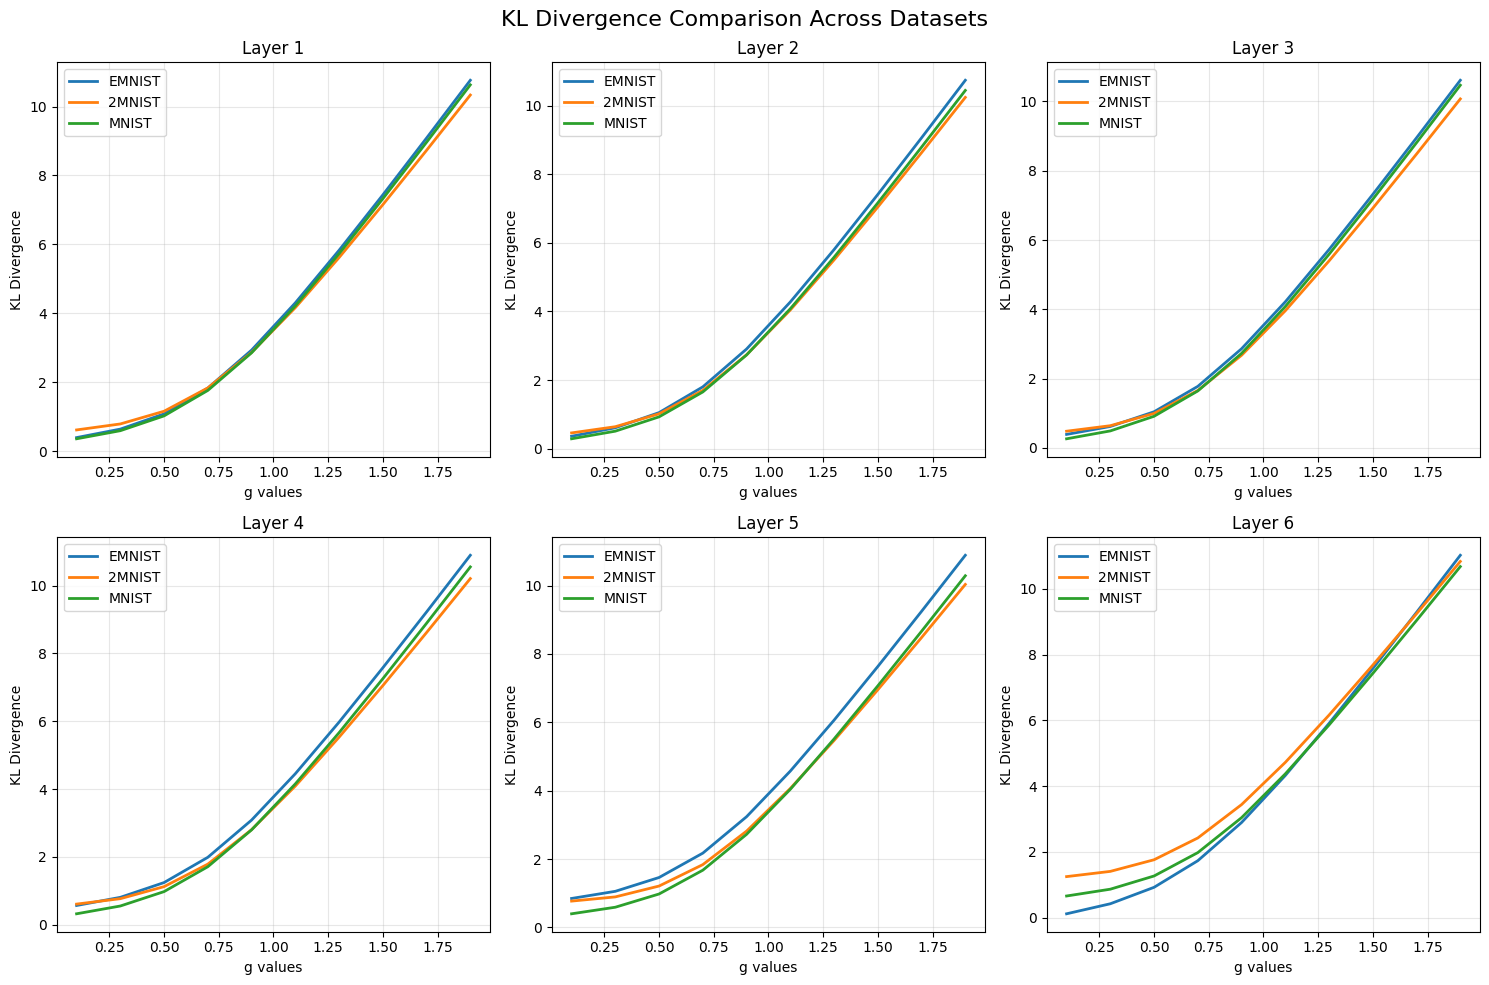

In [83]:
g_values = np.arange(0.1, 2, 0.2)

create_combined_comparison_plot(
    layer_dicts_CGMNIST_ld10_2, 
    layer_dicts_CGMNIST_ld10_M,
    layer_dicts_CGMNIST_ld10_E, 
    g_values,
    save_path="/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/comparisons/combined_dataset_comparison_01_2.png"
)

Combined plot saved to: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/comparisons/combined_dataset_comparison_01_2.png


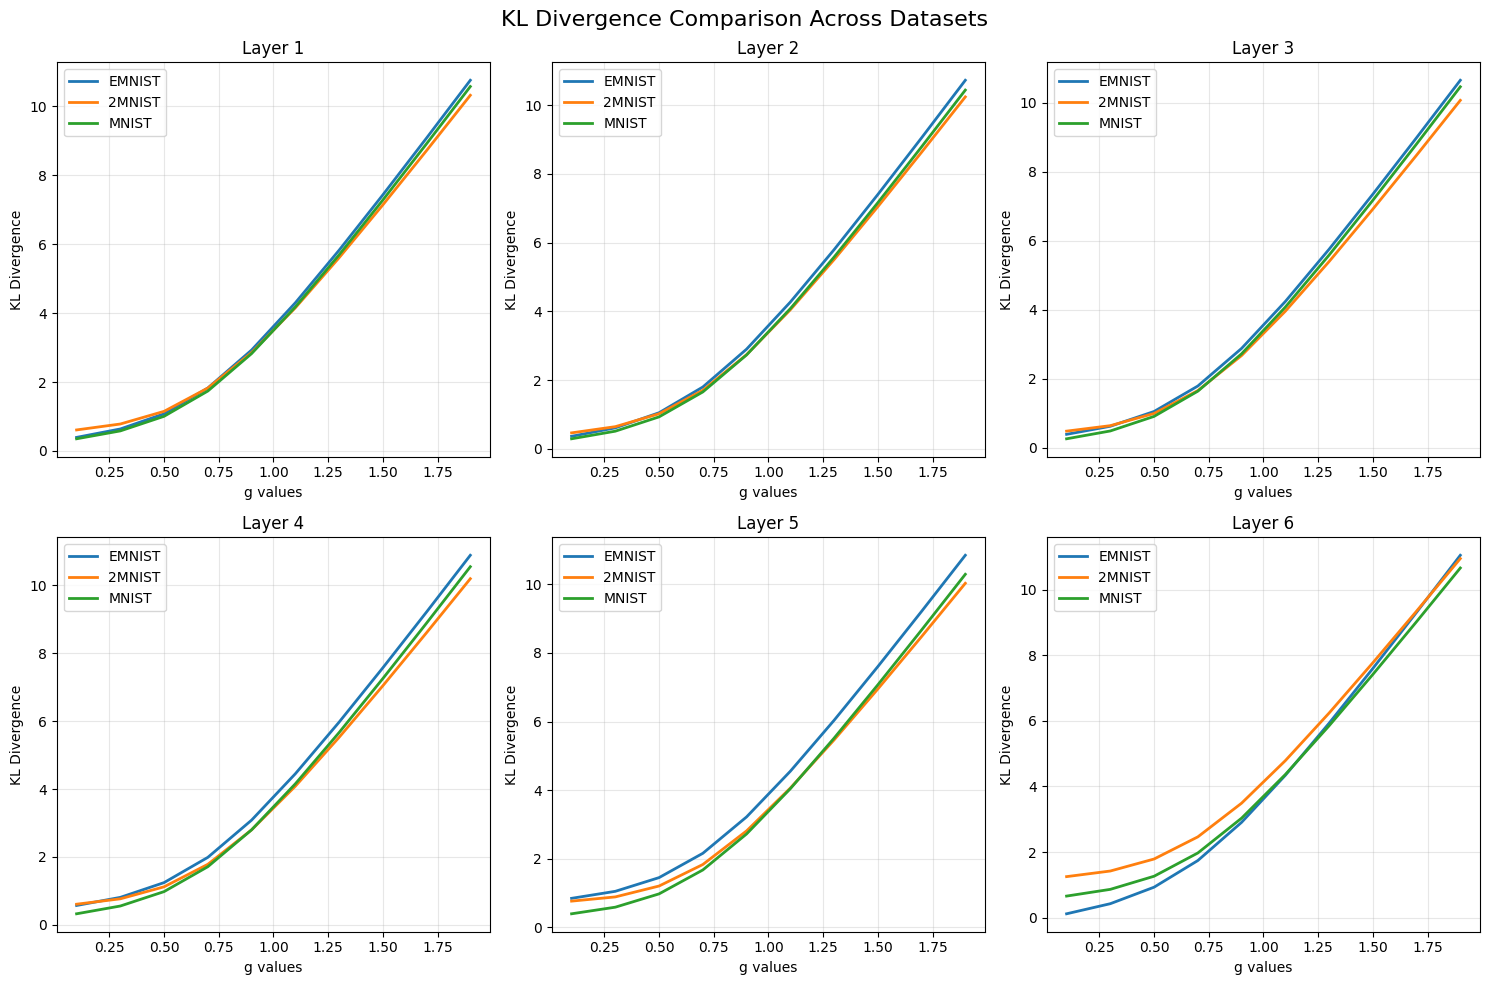

In [68]:
g_values = np.arange(0.1, 2, 0.2)

create_combined_comparison_plot(
    layer_dicts_CGMNIST_ld10_2, 
    layer_dicts_CGMNIST_ld10_M,
    layer_dicts_CGMNIST_ld10_E, 
    g_values,
    save_path="/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/CoarseGrainMNIST/comparisons/combined_dataset_comparison_01_2.png"
)

### FineGrain

Plot saved to: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/comparisons/6hl.png


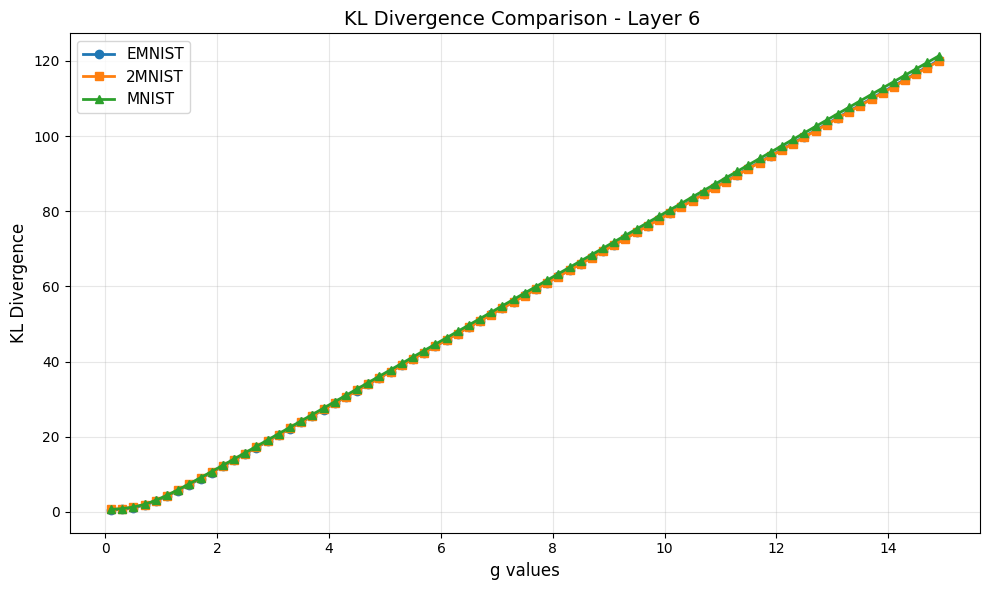

In [63]:
compare_datasets_by_layer(
    layer_dicts_FGMNIST_ld10_2, 
    layer_dicts_FGMNIST_ld10_M,
    layer_dicts_FGMNIST_ld10_E, 
    g_values, 
    layer_index=5,
    save_path="/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/comparisons/6hl.png"
)

Combined plot saved to: /Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/comparisons/combined_dataset_comparison_01_2__1.png


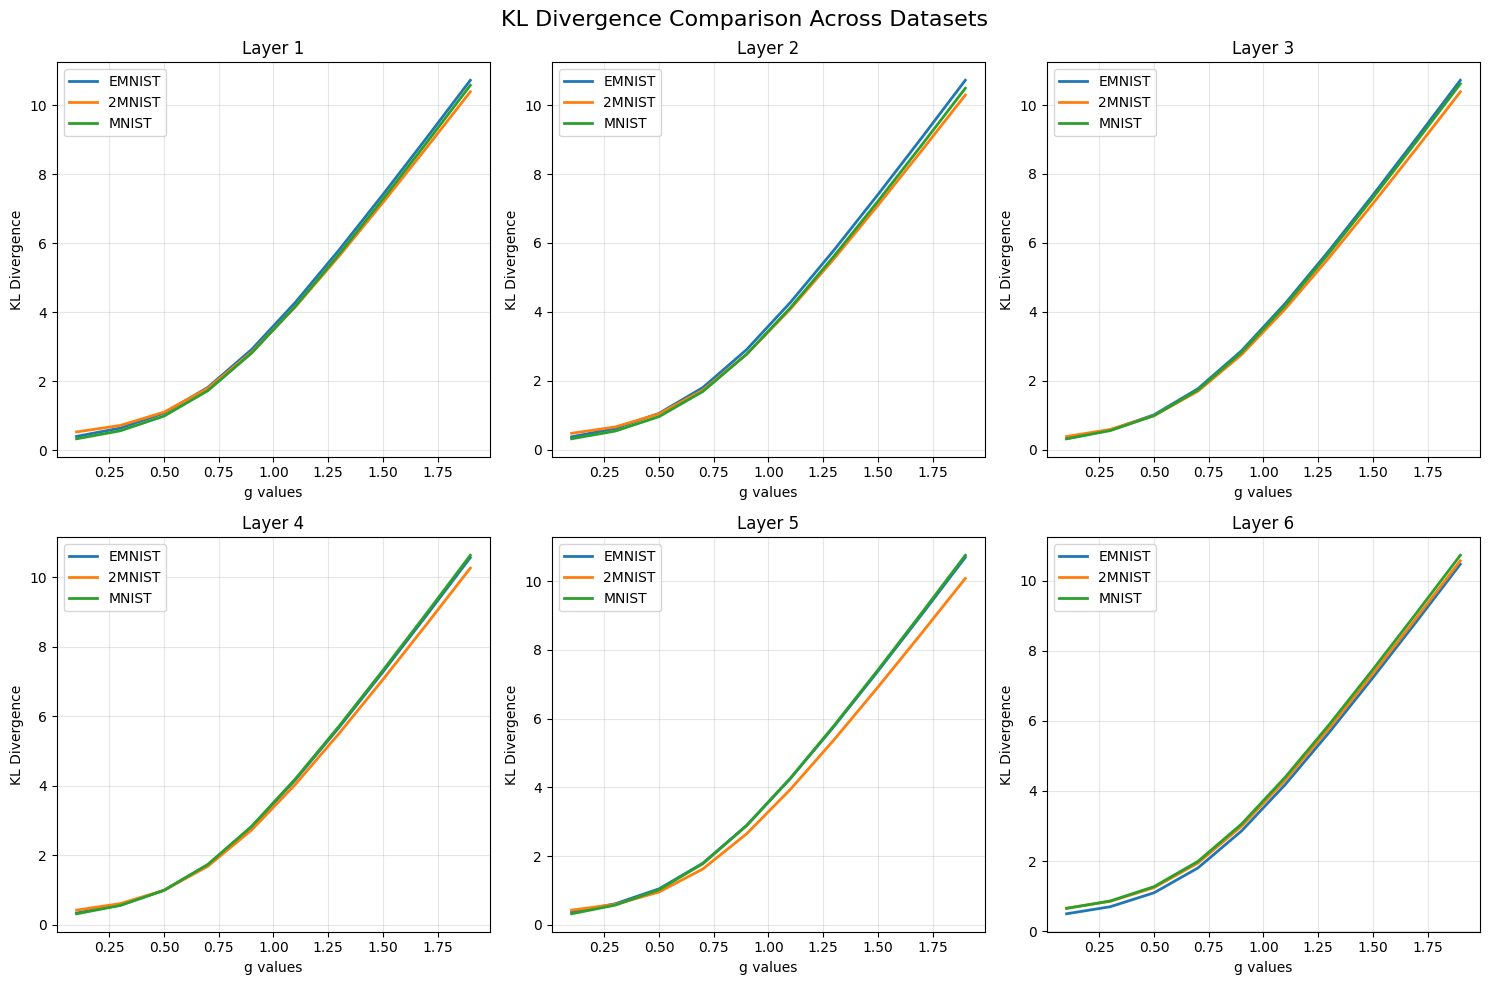

In [76]:
g_values = np.arange(0.1, 2, 0.2)

create_combined_comparison_plot(
    layer_dicts_FGMNIST_ld10_2, 
    layer_dicts_FGMNIST_ld10_M,
    layer_dicts_FGMNIST_ld10_E, 
    g_values,
    save_path="/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/10features/FineGrainMNIST/comparisons/combined_dataset_comparison_01_2__1.png"
)